In [1]:
# Open training, testing subsets from https://doi.org/10.1021/acs.energyfuels.0c01533
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds_train = [r for r in reader]
csv_file.close()
with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds_test = [r for r in reader]
csv_file.close()

print(len(compounds_train), len(compounds_test))

# Filter out compounds with `n.a.` RON or MON data
compounds_train = [c for c in compounds_train if c['Meas RON'] != 'n.a.']
compounds_test = [c for c in compounds_test if c['Meas RON'] != 'n.a.']

print(len(compounds_train), len(compounds_test))

430 75
284 51


In [2]:
# Format data for training
from ecnet.datasets.structs import QSPRDataset

smiles_train = [c[' SMILES'] for c in compounds_train]
ron_train = [[float(c['Meas RON'])] for c in compounds_train]
smiles_test = [c[' SMILES'] for c in compounds_test]
ron_test = [[float(c['Meas RON'])] for c in compounds_test]

dataset_train = QSPRDataset(smiles_train, ron_train, backend='alvadesc')
dataset_test = QSPRDataset(smiles_test, ron_test, backend='alvadesc')

print(len(dataset_train), len(dataset_test))

284 51


In [3]:
# Select most-influential descriptors w.r.t. RON for NN input variables
from ecnet.tasks.feature_selection import select_rfr

print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.99999, n_estimators=128, n_jobs=8)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(dataset_train.desc_names[:5], desc_imp[:5])

torch.Size([284, 5305]) torch.Size([51, 5305])
torch.Size([284, 1549]) torch.Size([51, 1549])
['SssCH2', 'ChiA_B(s)', 'GATS2m', 'Eta_L_A', 'SpMaxA_EA(bo)'] [0.2745721643992046, 0.16520916490887333, 0.0673375197137612, 0.05459734025780005, 0.026885077564045255]


Epoch: 0 | Train loss: 3559.504990555311 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 217.39886832796913 | Valid loss: 196.04808044433594
Epoch: 20 | Train loss: 193.7590194487236 | Valid loss: 144.3379364013672
Epoch: 30 | Train loss: 128.1373201468741 | Valid loss: 145.2206573486328
Epoch: 40 | Train loss: 107.0001494358403 | Valid loss: 98.55777740478516
Epoch: 50 | Train loss: 111.7977080009353 | Valid loss: 79.88290405273438
Epoch: 60 | Train loss: 81.21770287455527 | Valid loss: 73.94943237304688
Epoch: 70 | Train loss: 89.13830763409395 | Valid loss: 74.04153442382812
Epoch: 80 | Train loss: 60.85352117690682 | Valid loss: 62.8133659362793
Epoch: 90 | Train loss: 60.474834352591785 | Valid loss: 49.53165054321289
Epoch: 100 | Train loss: 51.541741742774356 | Valid loss: 45.59551239013672
Epoch: 110 | Train loss: 43.45986198819299 | Valid loss: 45.163116455078125
Epoch: 120 | Train loss: 47.15610004478777 | Valid loss: 45.582130432128906
Epoch: 130 | Train loss: 57.2

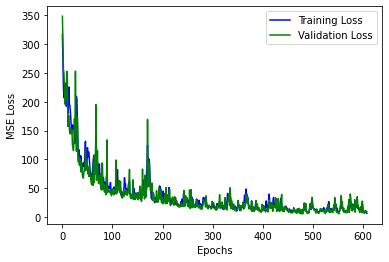

In [4]:
# Train model
from ecnet import ECNet
from matplotlib import pyplot as plt

model = ECNet(dataset_train.desc_vals.shape[1], dataset_train.target_vals.shape[1], 2048, 3, 0.0)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.25, shuffle=True, verbose=10,
    patience=128, epochs=2000, lr=0.0005, lr_decay=0.0
)

train_loss = train_loss[5:]
valid_loss = valid_loss[5:]

epoch = [i for i in range(len(train_loss))]
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals.numpy()
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals.numpy()

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_train = r2_score(y_train, y_hat_train)
r2_test = r2_score(y_test, y_hat_test)

print(f'Training set: {mae_train} | {r2_train}')
print(f'Testing set: {mae_test} | {r2_test}')

Training set: 1.8660348653793335 | 0.9894135688851871
Testing set: 5.474296569824219 | 0.8927051836356472


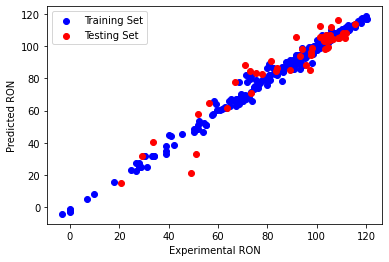

In [6]:
plt.clf()
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()